In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fercsv/fer2013.csv


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

In [3]:
df=pd.read_csv('/kaggle/input/fercsv/fer2013.csv')

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [6]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [7]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [8]:
k.shape

(48, 48)

In [9]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [10]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

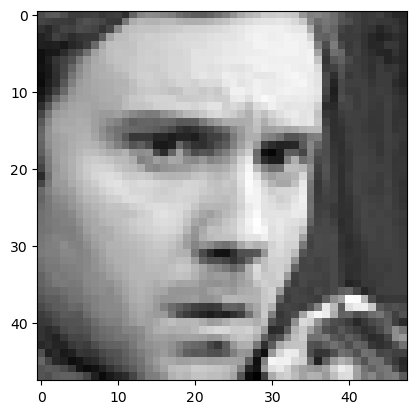

In [11]:
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')

In [12]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [13]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [14]:
X_train.shape

(28709, 48, 48, 1)

In [3]:
import keras
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

NameError: name 'y_train' is not defined

In [16]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

In [17]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

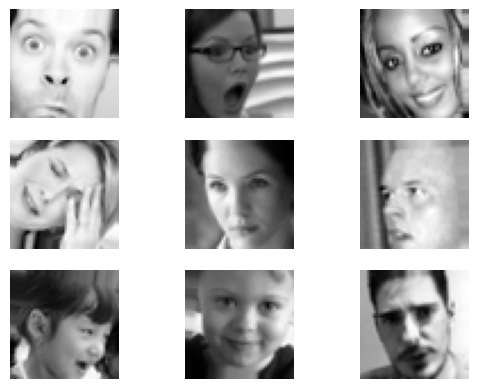

In [18]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

In [15]:
from keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Sequential

In [13]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [16]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

     #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
     #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [17]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [26]:
num_epochs = 100
history = model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=test_flow,  
                    validation_steps=len(X_test) / batch_size)

Epoch 1/100

Epoch 1: val_loss improved from 1.59014 to 1.42178, saving model to weights_min_loss.hdf5
448/448 - 23s - loss: 1.4920 - accuracy: 0.4181 - val_loss: 1.4218 - val_accuracy: 0.4684 - 23s/epoch - 51ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.42178 to 1.35718, saving model to weights_min_loss.hdf5
448/448 - 23s - loss: 1.4277 - accuracy: 0.4506 - val_loss: 1.3572 - val_accuracy: 0.4831 - 23s/epoch - 51ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.35718 to 1.31402, saving model to weights_min_loss.hdf5
448/448 - 22s - loss: 1.3687 - accuracy: 0.4743 - val_loss: 1.3140 - val_accuracy: 0.4896 - 22s/epoch - 50ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.31402 to 1.25995, saving model to weights_min_loss.hdf5
448/448 - 23s - loss: 1.3252 - accuracy: 0.4932 - val_loss: 1.2599 - val_accuracy: 0.5227 - 23s/epoch - 51ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.25995 to 1.21948, saving model to weights_min_loss.hdf5
448/448 - 23s - loss: 1.2771 

<Figure size 640x480 with 0 Axes>

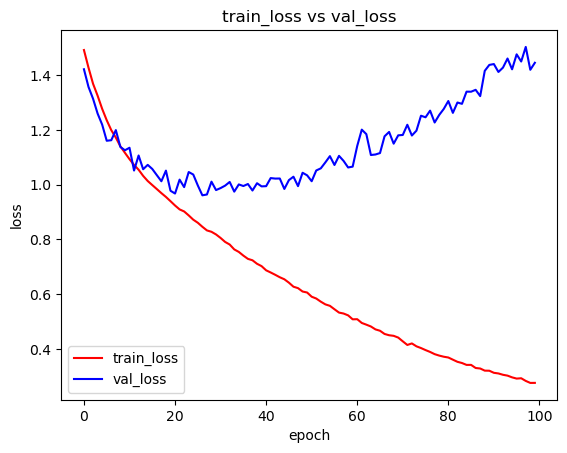

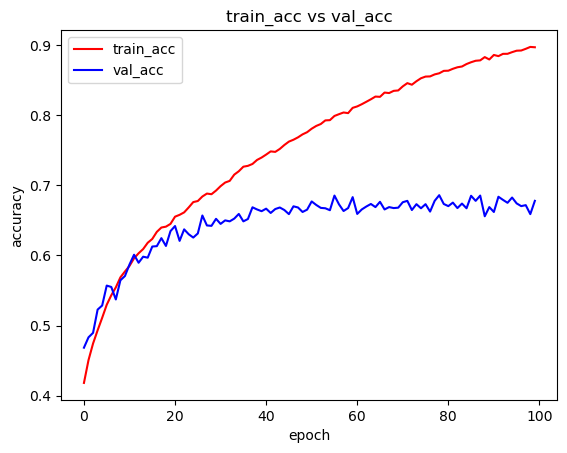

<Figure size 640x480 with 0 Axes>

In [27]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [31]:
model.save('../working/Fer2013.h5')

In [32]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 10ms/step - loss: 1.4454 - accuracy: 0.6776
Test Loss 1.4454319477081299
Test Acc: 0.6776260733604431


In [18]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk
